In [1]:
import logging

logging.basicConfig(level=logging.INFO)

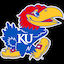

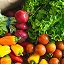

In [2]:
from pathlib import Path
from PIL import Image
from sympy import Matrix

from qcc.ml.quantum import MQCCLayer

from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter

dims = (64, 64, 3)

size = "x".join((str(dim) for dim in dims))
filenames = [Path(f"../img/color/Jayhawk_{size}.jpg"), Path(f"../img/color/Salad_{size}.jpg")]
batch_size = len(filenames)

for filename in filenames:
    with Image.open(filename, "r") as im:
        display(im)

def display_matrix(matrix):
    try:
        display(Matrix(matrix))
    except:
        print(matrix)

In [3]:
from qcc.filters import *

kernels_raw = [avg_filter(3, dim = 2), laplacian_approx(3)]
# kernel_raw = sobel_filter(3, axis=0)
# kernel_raw = laplacian_approx(3)
# kernel_raw = gaussian_blur(3)

kernels = []
for kernel_raw in kernels_raw:
    npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in kernel_raw.shape)
    kernel = np.pad(kernel_raw, pad_width=npad, mode="constant", constant_values=0)
    kernels += [kernel]

num_features = len(kernels)
kernel_shape = kernels_raw[0].shape

for kernel in kernels:
    display_matrix(kernel)

Matrix([
[0.111111111111111, 0.111111111111111, 0.111111111111111, 0],
[0.111111111111111, 0.111111111111111, 0.111111111111111, 0],
[0.111111111111111, 0.111111111111111, 0.111111111111111, 0],
[                0,                 0,                 0, 0]])

Matrix([
[0.166666666666667, 0.166666666666667, 0.166666666666667, 0],
[0.166666666666667, -1.33333333333333, 0.166666666666667, 0],
[0.166666666666667, 0.166666666666667, 0.166666666666667, 0],
[                0,                 0,                 0, 0]])

In [4]:
from qcc.quantum import normalize

inputs = []
for filename in filenames:
    with Image.open(filename) as im:
        inputs += [np.asarray(im, dtype=float)]
        
inputs = np.stack(inputs, axis=len(dims)).T

inputs.shape

(2, 3, 64, 64)

In [5]:
# inputs = (flatten_image(filename, pad=True)[0] for filename in filenames)

# inputs, magnitudes = zip(*(normalize(psi, include_magnitude=True) for psi in inputs))

# inputs, magnitudes = np.vstack(inputs), tuple(magnitudes)

INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 16
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 119


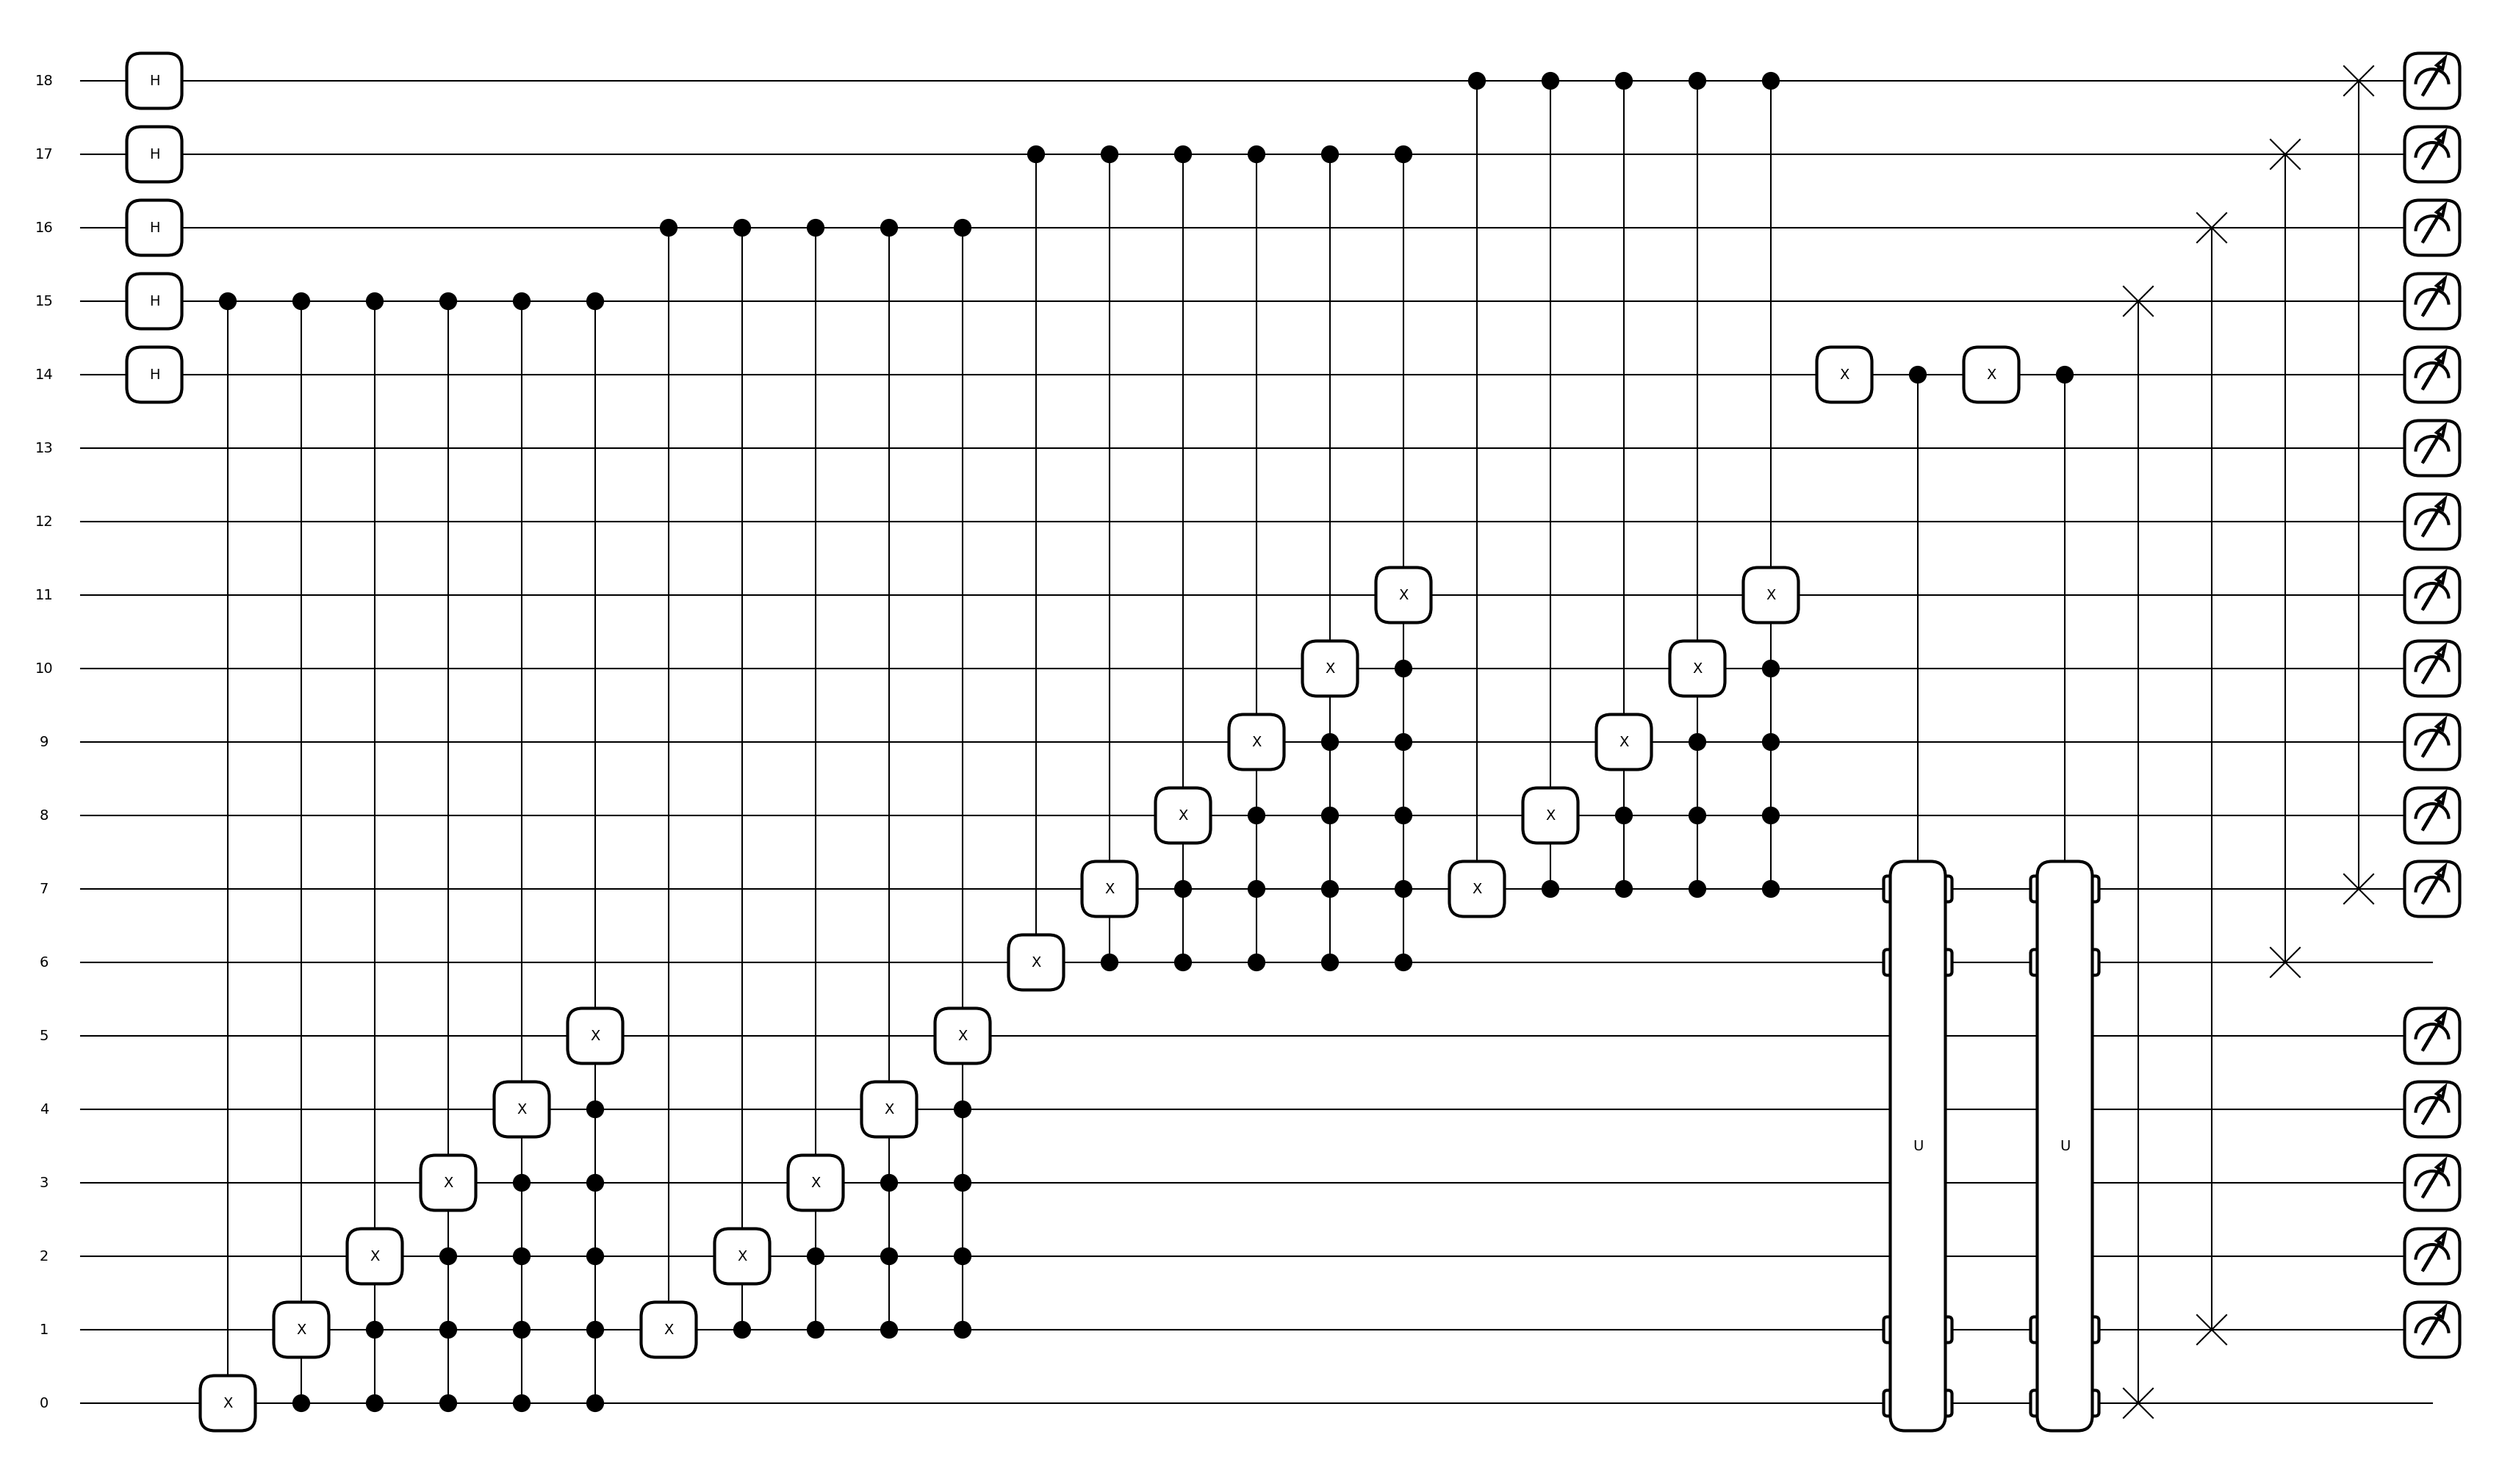

In [6]:
out_channels = len(kernels)
from qcc.ml.cnn import Layer
from qcc.ml.quantum import ConvolutionFilter

layer = Layer(MQCCLayer, kernel_size=kernel_shape)

module = layer(dims, in_channels=1, out_channels=out_channels, U_kernel=ConvolutionFilter, pooling=True, pooling_mode = "euclidean")

fig = module.mqcc.draw(decompose=True)

In [7]:
from torch import Tensor
from torch.nn import Parameter

params, kernels_mag = zip(*(normalize(kernel.flatten(order="F"), include_magnitude=True) for kernel in kernels))
params, kernels_mag = np.vstack(params), tuple(kernels_mag)

print(kernels_mag)

# PyTorch assume row-major order
print(module.mqcc.weight.shape)
module.mqcc.weight = Parameter(Tensor(params.flatten()))
print(module.mqcc.weight.shape)

print(module.filter_norm.shape)
module.filter_norm = Parameter(Tensor(kernels_mag))
print(module.filter_norm.shape)

display_matrix(module.mqcc.weight.data)



(0.3333333333333333, 1.414213562373095)
torch.Size([32])
torch.Size([32])
torch.Size([2])
torch.Size([2])


Matrix([
[ 0.333333],
[ 0.333333],
[ 0.333333],
[        0],
[ 0.333333],
[ 0.333333],
[ 0.333333],
[        0],
[ 0.333333],
[ 0.333333],
[ 0.333333],
[        0],
[        0],
[        0],
[        0],
[        0],
[ 0.117851],
[ 0.117851],
[ 0.117851],
[        0],
[ 0.117851],
[-0.942809],
[ 0.117851],
[        0],
[ 0.117851],
[ 0.117851],
[ 0.117851],
[        0],
[        0],
[        0],
[        0],
[        0]])

In [8]:
result = module(Tensor(inputs))

result.shape

torch.Size([2, 2, 3, 31, 31])

In [9]:
result = result.cpu().detach().numpy().T

In [10]:
result = np.moveaxis(result, -1, 0)
result = result.reshape((*result.shape[:-1], 1, num_features), order="F")
result = np.moveaxis(result, -1, 1)

for images in result:
    for img, kernel_mag in zip(images, kernels_mag):
        img = img[:,:,:, 0]
        
        print(img.shape, min(img.flatten()), max(img.flatten()))

        img = Image.fromarray(np.abs(img).astype(np.uint8))

        display(img)

(31, 31, 3) 0.46837354 254.88937


(31, 31, 3) 1.9871405 224.26308


(31, 31, 3) 3.2220979 253.72272


(31, 31, 3) 1.8928243 199.95029


In [ ]:
# TODO: check fidelity